This notebook contains cells to train GAN (Cramer GAN modification) to learn data distribution. Standard random train/test split is used.

**NOTE!** The code uses processed data from the LHCb experiment. Collaboration members please write nikita.kazeev@cern.ch for access.

In [ ]:
!pip install tensorflow-addons

     |████████████████████████████████| 1.1 MB 4.2 MB/s 


In [ ]:
import datetime
import os
import time

import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from experiments.efficiency.uncertainty_model_train import train_model
from experiments.efficiency.uncertainty_models import uncertainty_mlp
from experiments.efficiency.uncertainty_utils import \
    efficiency_momentum_with_uncertainty
from experiments.efficiency.utils import (efficiency_momentum,
                                          ensemble_and_ref_model_inference,
                                          tf_to_numpy_dataset,
                                          threshold_selection)
from src.dataset import CramerGANDataset
from src.cramer_gan_trainer import CramerGANTrainer
from src.datasets.utils_rich import (get_merged_typed_dataset,
                                     parse_dataset_np, parse_example)

from src.models.gans.discriminators.fcn_disc import RICHDiscriminator
from src.models.gans.generators.fcn_gen import RichMCDropV2Subcl

### Data preparation

The RICH dataset contains sets of data for different types of particles. Each datapoint in RICH consists of $\mathbb{X}, \mathbb{Y}$ and weight $w$, where the input data $\mathbb{X} \in \mathbb{R}^3$, where features of input data consist of pseudorapidity (ETA), momentum (P), number of tracks; the output is data $\mathbb{Y} \in \mathbb{R}^5$, where each feature is the difference of log-likelihood values between particle hypothesis and pion hypothesis. The particles are kaon, proton, muon, electron, and values below the threshold.

In [ ]:
particle_type = 'pion'

data_dir = 'rich'

In [ ]:
ls rich

kaon2_-_down_2016_.csv  muon_-_down_2016_.csv   pion_-_down_2016_.csv
kaon2_+_down_2016_.csv  muon_+_down_2016_.csv   pion_+_down_2016_.csv
kaon2_-_up_2016_.csv    muon_-_up_2016_.csv     pion_-_up_2016_.csv
kaon2_+_up_2016_.csv    muon_+_up_2016_.csv     pion_+_up_2016_.csv
kaon_-_down_2016_.csv   pion2_-_down_2016_.csv  proton_-_down_2016_.csv
kaon_+_down_2016_.csv   pion2_+_down_2016_.csv  proton_+_down_2016_.csv
kaon_-_up_2016_.csv     pion2_-_up_2016_.csv    proton_-_up_2016_.csv
kaon_+_up_2016_.csv     pion2_+_up_2016_.csv    proton_+_up_2016_.csv


In [ ]:
def bootstrap_sampling(data_train, data_val, sample_size=int(1.5e6)):
    data_train_sample = data_train.sample(sample_size, replace=False)

    return data_train_sample, data_val

In [ ]:
data_train, data_val, scaler = get_merged_typed_dataset(data_dir, particle_type, 
                                                        dtype=np.float32, log=True, 
                                                        sample_fn=None)

Reading and concatenating datasets:
	drive/MyDrive/uncertainty-colab/datasets/rich/pion_-_down_2016_.csv
	drive/MyDrive/uncertainty-colab/datasets/rich/pion_+_down_2016_.csv
	drive/MyDrive/uncertainty-colab/datasets/rich/pion_-_up_2016_.csv
	drive/MyDrive/uncertainty-colab/datasets/rich/pion_+_up_2016_.csv
	drive/MyDrive/uncertainty-colab/datasets/rich/pion2_-_down_2016_.csv
	drive/MyDrive/uncertainty-colab/datasets/rich/pion2_+_down_2016_.csv
	drive/MyDrive/uncertainty-colab/datasets/rich/pion2_-_up_2016_.csv
	drive/MyDrive/uncertainty-colab/datasets/rich/pion2_+_up_2016_.csv
splitting to train/val/test
fitting the scaler
scaler train sample size: 2000000
scaler n_quantiles: 100000, time = 2.0309267044067383
scaling train set
scaling test set
converting dtype to <class 'numpy.float32'>


In [ ]:
data_train.head()

RichDLLe  RichDLLk  RichDLLmu  ...  Brunel_ETA  nTracks_Brunel  probe_sWeight
0  1.374413 -0.168298   0.839823  ...   -0.306364       -0.224346       1.204700
1 -1.254825 -0.040824  -1.886267  ...   -0.669189       -0.548956       0.965707
2  0.931232  1.038058   0.607882  ...    1.356350       -0.475871       0.665584
3  1.128034 -0.207232   0.942811  ...    0.534500       -1.278361       0.581925
4  1.315219 -0.190440   1.180111  ...    0.147866       -0.578887       0.118914

[5 rows x 9 columns]

In [ ]:
data_val.head()

RichDLLe  RichDLLk  RichDLLmu  ...  Brunel_ETA  nTracks_Brunel  probe_sWeight
0  0.642078  0.247975   0.790279  ...    1.312073       -0.548956       0.859352
1  0.410903 -2.077369   0.448014  ...   -2.181621        0.474075       0.957473
2 -0.653586 -1.325109  -0.581912  ...   -0.918851        0.748689       0.825602
3 -0.396800 -1.025127   1.549422  ...    1.381592       -0.608697      -1.011210
4  0.295756  0.260714  -0.013731  ...    0.593576        1.160335       1.234150

[5 rows x 9 columns]

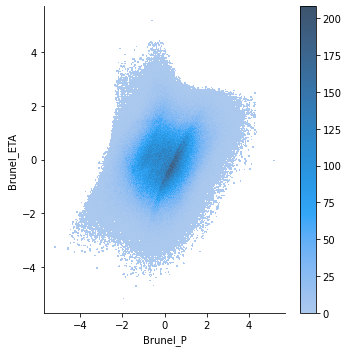

In [ ]:
sns.displot(data_train, x='Brunel_P', y='Brunel_ETA', cbar=True)

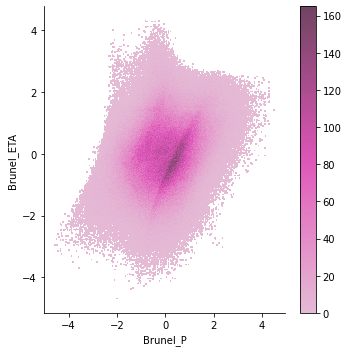

In [ ]:
sns.displot(data_val, x='Brunel_P', y='Brunel_ETA', cbar=True, color='tab:pink')

In [ ]:
data_train.shape, data_val.shape

((2000000, 9), (1000000, 9))

### Model definition

The generator is six-layer mlp with dropout after each layer except last. Each hidden layer contains 128 units. The dropout rate is usually in the range of 0.1 - 0.2 (calibration results). This rate is enough to train a "diverse" ensemble keeping the performance on benchmark at a considerable level. The discriminator is six-layer mlp. 


In [ ]:
generator = RichMCDropV2Subcl(drop_rate=0.0)
generator.build((None, 3))
generator.summary()

Model: "rich_mc_drop_v2_subcl"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_drop (DenseDrop)       multiple                  8704      
_________________________________________________________________
dense_drop_1 (DenseDrop)     multiple                  16512     
_________________________________________________________________
dense_drop_2 (DenseDrop)     multiple                  16512     
_________________________________________________________________
dense_drop_3 (DenseDrop)     multiple                  16512     
_________________________________________________________________
dense_drop_4 (DenseDrop)     multiple                  16512     
_________________________________________________________________
dense_5 (Dense)              multiple                  645       
Total params: 75,397
Trainable params: 75,397
Non-trainable params: 0
_________________________________________

In [ ]:
discriminator = RICHDiscriminator()
discriminator.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 3)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 5)]          0                                            
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 8)            0           input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
sequential (Sequential)         (None, 256)          100224      concatenate[0][0]            

We use Cramer GAN modification to train generator learn the distribution. [Link](https://arxiv.org/abs/1705.10743) to Cramer GAN for more details. The training configuration:
 - Batch size: 1000
 - Critic steps: 15
 - Generator optimizer: RMSProp with learning rate 0.0002
 - Discriminator optimizer: RMSProp with learning rate 0.0002
 - Use weights: True
 - Number of epochs: 400

In [ ]:
critic_batch_size = 15
batch_size = int(1e3)

num_val = data_val.shape[0]
num_train = data_train.shape[0]

train_dataset_config = {
    'data_np': data_train,
    'iter_batch_size': critic_batch_size + 1,
    'batch_size': batch_size
}

val_dataset_config = {
    'data_np': data_val,
    'num_instances': 1,
    'iter_batch_size': 1,
    'batch_size': num_val,
    'shuffle': False
}

dataset_train = CramerGANDataset(**train_dataset_config)
dataset_val = CramerGANDataset(**val_dataset_config)

print("Train dataset shape: ", tf.data.experimental.cardinality(dataset_train.dataset))
print("Val dataset shape: ", tf.data.experimental.cardinality(dataset_val.dataset))

Train dataset shape:  tf.Tensor(125, shape=(), dtype=int64)
Val dataset shape:  tf.Tensor(1, shape=(), dtype=int64)


In [ ]:
checkpoint_base = 'checkpoints'
exp_name = 'btstrap_cramer_weighted_model_ref'
checkpoint_dir = os.path.join(checkpoint_base, exp_name)

logs_base = 'logs'
log_dir = os.path.join(logs_base, exp_name)

generator_optimizer = tf.keras.optimizers.RMSprop(2e-4) 
discriminator_optimizer = tf.keras.optimizers.RMSprop(2e-4)

trainer_config = {
    'generator': generator,
    'discriminator': discriminator,
    'generator_optimizer': generator_optimizer,
    'discriminator_optimizer': discriminator_optimizer,
    'checkpoint_dir': checkpoint_dir,
    'log_dir': log_dir
}

trainer = CramerGANTrainer(**trainer_config)

In [ ]:
trainer.fit_cramer(400, dataset_train, dataset_val, weighted=True)

  3%|▎         | 64000/2000000 [00:22<08:45, 3682.08it/s, gen_loss=0.712, disc_loss=-.644]

  4%|▍         | 80000/2000000 [00:25<07:32, 4238.73it/s, gen_loss=0.801, disc_loss=-.798]

100%|██████████| 2000000/2000000 [06:03<00:00, 5498.18it/s, gen_loss=0.197, disc_loss=-.188]


Time taken for epoch 1 is 363.76252269744873 sec



100%|██████████| 2000000/2000000 [02:22<00:00, 14072.34it/s, gen_loss=0.357, disc_loss=-.183]


Time taken for epoch 2 is 142.12798261642456 sec



100%|██████████| 2000000/2000000 [01:56<00:00, 17233.12it/s, gen_loss=0.182, disc_loss=-.326]


Time taken for epoch 3 is 116.06116962432861 sec



100%|██████████| 2000000/2000000 [02:22<00:00, 14079.84it/s, gen_loss=-.0509, disc_loss=-.198]


Time taken for epoch 4 is 142.05524921417236 sec



100%|██████████| 2000000/2000000 [01:55<00:00, 17362.05it/s, gen_loss=0.165, disc_loss=-.675]


Time taken for epoch 5 is 115.20044302940369 sec



100%|██████████| 2000000/2000000 [01:54<00:00, 17472.17it/s, gen_loss=0.0703, disc_loss=0.00813]


Time taken for epoch 6 is 114.47290277481079 sec



100%|██████████| 2000000/2000000 [02:22<00:00, 14080.30it/s, gen_loss=0.15, disc_loss=-.0283]


Time taken for epoch 7 is 142.0491099357605 sec



100%|██████████| 2000000/2000000 [01:53<00:00, 17601.72it/s, gen_loss=-.0326, disc_loss=-.0843]


Time taken for epoch 8 is 113.63101363182068 sec



100%|██████████| 2000000/2000000 [01:52<00:00, 17741.69it/s, gen_loss=0.0769, disc_loss=-.0891]


Time taken for epoch 9 is 112.73451161384583 sec



100%|██████████| 2000000/2000000 [01:50<00:00, 18066.12it/s, gen_loss=-.00263, disc_loss=-.0694]


Time taken for epoch 10 is 110.71149802207947 sec



100%|██████████| 2000000/2000000 [02:22<00:00, 14080.21it/s, gen_loss=0.16, disc_loss=-.136]


Time taken for epoch 11 is 142.05117630958557 sec



100%|██████████| 2000000/2000000 [02:22<00:00, 14080.76it/s, gen_loss=0.0136, disc_loss=0.00197]


Time taken for epoch 12 is 142.04325580596924 sec



100%|██████████| 2000000/2000000 [01:53<00:00, 17619.50it/s, gen_loss=0.29, disc_loss=-.0239]


Time taken for epoch 13 is 113.51556158065796 sec



100%|██████████| 2000000/2000000 [01:52<00:00, 17728.07it/s, gen_loss=-.000911, disc_loss=0.168]


Time taken for epoch 14 is 112.82085752487183 sec



100%|██████████| 2000000/2000000 [01:51<00:00, 17914.07it/s, gen_loss=-.422, disc_loss=0.333]


Time taken for epoch 15 is 111.64983940124512 sec



100%|██████████| 2000000/2000000 [01:50<00:00, 18081.89it/s, gen_loss=0.07, disc_loss=-.169]


Time taken for epoch 16 is 110.61535048484802 sec



100%|██████████| 2000000/2000000 [01:50<00:00, 18157.97it/s, gen_loss=0.228, disc_loss=-.487]


Time taken for epoch 17 is 110.1487193107605 sec



100%|██████████| 2000000/2000000 [01:50<00:00, 18075.51it/s, gen_loss=0.151, disc_loss=0.0205]


Time taken for epoch 18 is 110.65595388412476 sec



100%|██████████| 2000000/2000000 [02:22<00:00, 14081.03it/s, gen_loss=0.149, disc_loss=-.111]


Time taken for epoch 19 is 142.0409746170044 sec



100%|██████████| 2000000/2000000 [02:22<00:00, 14079.95it/s, gen_loss=-.00628, disc_loss=0.337]


Time taken for epoch 20 is 142.1482036113739 sec



100%|██████████| 2000000/2000000 [01:54<00:00, 17541.77it/s, gen_loss=-.138, disc_loss=0.0437]


Time taken for epoch 21 is 114.01944613456726 sec



100%|██████████| 2000000/2000000 [01:54<00:00, 17520.94it/s, gen_loss=0.0871, disc_loss=-.129]


Time taken for epoch 22 is 114.15598201751709 sec



100%|██████████| 2000000/2000000 [01:51<00:00, 17859.48it/s, gen_loss=-.221, disc_loss=0.296]


Time taken for epoch 23 is 111.992666721344 sec



100%|██████████| 2000000/2000000 [01:50<00:00, 18078.81it/s, gen_loss=-.105, disc_loss=-.0778]


Time taken for epoch 24 is 110.63541150093079 sec



100%|██████████| 2000000/2000000 [01:50<00:00, 18068.90it/s, gen_loss=0.0217, disc_loss=-.431]


Time taken for epoch 25 is 110.69308924674988 sec



100%|██████████| 2000000/2000000 [01:50<00:00, 18137.70it/s, gen_loss=0.0343, disc_loss=-.184]


Time taken for epoch 26 is 110.27356004714966 sec



100%|██████████| 2000000/2000000 [01:50<00:00, 18135.75it/s, gen_loss=0.0434, disc_loss=-.0895]


Time taken for epoch 27 is 110.28668522834778 sec



100%|██████████| 2000000/2000000 [01:49<00:00, 18187.86it/s, gen_loss=-.097, disc_loss=-.244]


Time taken for epoch 28 is 109.96967482566833 sec



100%|██████████| 2000000/2000000 [01:49<00:00, 18300.10it/s, gen_loss=0.176, disc_loss=-.224]


Time taken for epoch 29 is 109.29610872268677 sec



100%|██████████| 2000000/2000000 [01:50<00:00, 18126.86it/s, gen_loss=0.122, disc_loss=-.0692]


Time taken for epoch 30 is 110.33870911598206 sec



100%|██████████| 2000000/2000000 [01:49<00:00, 18232.43it/s, gen_loss=-.0333, disc_loss=-.0615]


Time taken for epoch 31 is 109.7015597820282 sec



100%|██████████| 2000000/2000000 [01:49<00:00, 18239.85it/s, gen_loss=0.218, disc_loss=-.0854]


Time taken for epoch 32 is 109.65704011917114 sec



100%|██████████| 2000000/2000000 [01:50<00:00, 18176.90it/s, gen_loss=0.0569, disc_loss=0.2]


Time taken for epoch 33 is 110.03633952140808 sec



100%|██████████| 2000000/2000000 [01:50<00:00, 18145.88it/s, gen_loss=0.157, disc_loss=0.0284]


Time taken for epoch 34 is 110.22358012199402 sec



100%|██████████| 2000000/2000000 [01:49<00:00, 18287.77it/s, gen_loss=0.234, disc_loss=0.196]


Time taken for epoch 35 is 109.36776232719421 sec



100%|██████████| 2000000/2000000 [01:49<00:00, 18217.36it/s, gen_loss=-.127, disc_loss=-.026]


Time taken for epoch 36 is 109.7915689945221 sec



100%|██████████| 2000000/2000000 [01:50<00:00, 18158.28it/s, gen_loss=-.163, disc_loss=0.0974]


Time taken for epoch 37 is 110.14784812927246 sec



100%|██████████| 2000000/2000000 [02:22<00:00, 14080.81it/s, gen_loss=0.0548, disc_loss=0.162]


Time taken for epoch 38 is 142.04339981079102 sec



100%|██████████| 2000000/2000000 [01:51<00:00, 17994.18it/s, gen_loss=0.107, disc_loss=0.306]


Time taken for epoch 39 is 111.15279412269592 sec



100%|██████████| 2000000/2000000 [01:51<00:00, 17909.20it/s, gen_loss=-.0276, disc_loss=-.18]


Time taken for epoch 40 is 111.77307057380676 sec



100%|██████████| 2000000/2000000 [01:51<00:00, 17973.50it/s, gen_loss=-.215, disc_loss=-.12]


Time taken for epoch 41 is 111.27911686897278 sec



100%|██████████| 2000000/2000000 [01:51<00:00, 17959.60it/s, gen_loss=0.196, disc_loss=-.0823]


Time taken for epoch 42 is 111.36605548858643 sec



100%|██████████| 2000000/2000000 [01:50<00:00, 18099.05it/s, gen_loss=0.178, disc_loss=-.307]


Time taken for epoch 43 is 110.50875186920166 sec



100%|██████████| 2000000/2000000 [02:22<00:00, 14080.10it/s, gen_loss=0.481, disc_loss=-.1]


Time taken for epoch 44 is 142.0512819290161 sec



100%|██████████| 2000000/2000000 [02:22<00:00, 14079.54it/s, gen_loss=0.0746, disc_loss=0.183]


Time taken for epoch 45 is 142.05463862419128 sec



100%|██████████| 2000000/2000000 [01:54<00:00, 17411.13it/s, gen_loss=-.0416, disc_loss=-.171]


Time taken for epoch 46 is 114.87644720077515 sec



100%|██████████| 2000000/2000000 [01:54<00:00, 17472.93it/s, gen_loss=0.32, disc_loss=-.524]


Time taken for epoch 47 is 114.46919703483582 sec



100%|██████████| 2000000/2000000 [01:53<00:00, 17612.94it/s, gen_loss=-.153, disc_loss=-.295]


Time taken for epoch 48 is 113.5587990283966 sec



100%|██████████| 2000000/2000000 [01:52<00:00, 17778.53it/s, gen_loss=0.282, disc_loss=0.252]


Time taken for epoch 49 is 112.50127053260803 sec



100%|██████████| 2000000/2000000 [01:51<00:00, 17942.81it/s, gen_loss=0.0682, disc_loss=-.251]


Time taken for epoch 50 is 111.47064256668091 sec



100%|██████████| 2000000/2000000 [01:51<00:00, 17943.60it/s, gen_loss=0.0328, disc_loss=-.177]


Time taken for epoch 51 is 111.4681932926178 sec



100%|██████████| 2000000/2000000 [01:50<00:00, 18127.27it/s, gen_loss=0.232, disc_loss=0.194]


Time taken for epoch 52 is 110.33628058433533 sec



100%|██████████| 2000000/2000000 [01:49<00:00, 18183.71it/s, gen_loss=0.344, disc_loss=-.589]


Time taken for epoch 53 is 109.99696111679077 sec



100%|██████████| 2000000/2000000 [01:48<00:00, 18366.66it/s, gen_loss=0.042, disc_loss=0.106]


Time taken for epoch 54 is 108.89845871925354 sec



100%|██████████| 2000000/2000000 [02:22<00:00, 14079.51it/s, gen_loss=-.266, disc_loss=-.289]


Time taken for epoch 55 is 142.0562117099762 sec



100%|██████████| 2000000/2000000 [01:50<00:00, 18113.79it/s, gen_loss=0.144, disc_loss=0.015]


Time taken for epoch 56 is 110.4195544719696 sec



100%|██████████| 2000000/2000000 [02:22<00:00, 14080.57it/s, gen_loss=-.0518, disc_loss=-.197]


Time taken for epoch 57 is 142.04479598999023 sec



100%|██████████| 2000000/2000000 [01:53<00:00, 17586.97it/s, gen_loss=0.187, disc_loss=-.0316]


Time taken for epoch 58 is 113.725261926651 sec



100%|██████████| 2000000/2000000 [01:53<00:00, 17641.73it/s, gen_loss=0.0541, disc_loss=0.0117]


Time taken for epoch 59 is 113.37208938598633 sec



100%|██████████| 2000000/2000000 [01:52<00:00, 17824.64it/s, gen_loss=0.399, disc_loss=-.363]


Time taken for epoch 60 is 112.28099751472473 sec



100%|██████████| 2000000/2000000 [01:50<00:00, 18069.52it/s, gen_loss=-.0149, disc_loss=0.168]


Time taken for epoch 61 is 110.68890476226807 sec



100%|██████████| 2000000/2000000 [01:49<00:00, 18192.41it/s, gen_loss=-.0852, disc_loss=0.426]


Time taken for epoch 62 is 109.94146037101746 sec



100%|██████████| 2000000/2000000 [01:50<00:00, 18120.18it/s, gen_loss=-.0207, disc_loss=-.139]


Time taken for epoch 63 is 110.38142132759094 sec



100%|██████████| 2000000/2000000 [01:49<00:00, 18259.93it/s, gen_loss=-.0248, disc_loss=0.0734]


Time taken for epoch 64 is 109.53761458396912 sec



100%|██████████| 2000000/2000000 [01:49<00:00, 18185.32it/s, gen_loss=0.211, disc_loss=-.228]


Time taken for epoch 65 is 109.98587822914124 sec



100%|██████████| 2000000/2000000 [01:48<00:00, 18355.48it/s, gen_loss=-.0351, disc_loss=0.141]


Time taken for epoch 66 is 108.96798181533813 sec



100%|██████████| 2000000/2000000 [01:49<00:00, 18249.44it/s, gen_loss=-.234, disc_loss=0.00262]


Time taken for epoch 67 is 109.59742546081543 sec



100%|██████████| 2000000/2000000 [01:49<00:00, 18245.32it/s, gen_loss=-.0435, disc_loss=-.119]


Time taken for epoch 68 is 109.62206172943115 sec



100%|██████████| 2000000/2000000 [02:22<00:00, 14080.55it/s, gen_loss=0.0996, disc_loss=-.26]


Time taken for epoch 69 is 142.04871773719788 sec



100%|██████████| 2000000/2000000 [01:51<00:00, 17923.91it/s, gen_loss=0.326, disc_loss=0.164]


Time taken for epoch 70 is 111.58955502510071 sec



100%|██████████| 2000000/2000000 [01:51<00:00, 17997.09it/s, gen_loss=0.0889, disc_loss=0.181]


Time taken for epoch 71 is 111.1342179775238 sec



100%|██████████| 2000000/2000000 [01:50<00:00, 18086.00it/s, gen_loss=0.24, disc_loss=-.276]


Time taken for epoch 72 is 110.58793234825134 sec



100%|██████████| 2000000/2000000 [01:50<00:00, 18181.47it/s, gen_loss=-.103, disc_loss=-.153]


Time taken for epoch 73 is 110.00834274291992 sec



100%|██████████| 2000000/2000000 [01:50<00:00, 18178.85it/s, gen_loss=0.117, disc_loss=-.21]


Time taken for epoch 74 is 110.02366161346436 sec



100%|██████████| 2000000/2000000 [01:49<00:00, 18226.16it/s, gen_loss=-.168, disc_loss=-.168]


Time taken for epoch 75 is 109.73718237876892 sec



100%|██████████| 2000000/2000000 [02:22<00:00, 14079.97it/s, gen_loss=0.114, disc_loss=0.209]


Time taken for epoch 76 is 142.05581712722778 sec



100%|██████████| 2000000/2000000 [01:51<00:00, 17980.96it/s, gen_loss=0.29, disc_loss=0.442]


Time taken for epoch 77 is 111.23841619491577 sec



100%|██████████| 2000000/2000000 [02:22<00:00, 14079.25it/s, gen_loss=0.0623, disc_loss=-.0309]


Time taken for epoch 78 is 142.05767512321472 sec



100%|██████████| 2000000/2000000 [01:53<00:00, 17640.13it/s, gen_loss=0.06, disc_loss=-.0321]


Time taken for epoch 79 is 113.3830406665802 sec



100%|██████████| 2000000/2000000 [01:52<00:00, 17814.58it/s, gen_loss=-.267, disc_loss=0.168]


Time taken for epoch 80 is 112.35490703582764 sec



100%|██████████| 2000000/2000000 [01:51<00:00, 17972.69it/s, gen_loss=-.119, disc_loss=-.235]


Time taken for epoch 81 is 111.28460741043091 sec



100%|██████████| 2000000/2000000 [02:22<00:00, 14080.03it/s, gen_loss=0.0212, disc_loss=-.0664]


Time taken for epoch 82 is 142.053386926651 sec



100%|██████████| 2000000/2000000 [01:52<00:00, 17707.67it/s, gen_loss=-.18, disc_loss=-.167]


Time taken for epoch 83 is 112.9499921798706 sec



100%|██████████| 2000000/2000000 [01:51<00:00, 17991.16it/s, gen_loss=-.022, disc_loss=-.314]


Time taken for epoch 84 is 111.17085361480713 sec



100%|██████████| 2000000/2000000 [01:50<00:00, 18107.19it/s, gen_loss=0.0184, disc_loss=-.0481]


Time taken for epoch 85 is 110.46210932731628 sec



100%|██████████| 2000000/2000000 [01:49<00:00, 18239.23it/s, gen_loss=-.0854, disc_loss=-.0222]


Time taken for epoch 86 is 109.66046142578125 sec



100%|██████████| 2000000/2000000 [01:49<00:00, 18236.17it/s, gen_loss=-.0691, disc_loss=0.085]


Time taken for epoch 87 is 109.6802089214325 sec



100%|██████████| 2000000/2000000 [01:50<00:00, 18168.46it/s, gen_loss=0.0806, disc_loss=-.0271]


Time taken for epoch 88 is 110.0904176235199 sec



100%|██████████| 2000000/2000000 [01:49<00:00, 18189.46it/s, gen_loss=0.0111, disc_loss=-.0983]


Time taken for epoch 89 is 109.96327757835388 sec



100%|██████████| 2000000/2000000 [01:49<00:00, 18239.17it/s, gen_loss=0.189, disc_loss=0.000239]


Time taken for epoch 90 is 109.65990543365479 sec



100%|██████████| 2000000/2000000 [02:22<00:00, 14079.83it/s, gen_loss=0.0432, disc_loss=-.0116]


Time taken for epoch 91 is 142.05198860168457 sec



100%|██████████| 2000000/2000000 [01:50<00:00, 18077.83it/s, gen_loss=0.391, disc_loss=0.271]


Time taken for epoch 92 is 110.63773250579834 sec



100%|██████████| 2000000/2000000 [01:49<00:00, 18186.76it/s, gen_loss=-.108, disc_loss=-.0745]


Time taken for epoch 93 is 109.97816514968872 sec



100%|██████████| 2000000/2000000 [01:50<00:00, 18159.26it/s, gen_loss=-.15, disc_loss=-.123]


Time taken for epoch 94 is 110.14345741271973 sec



100%|██████████| 2000000/2000000 [02:22<00:00, 14080.87it/s, gen_loss=-.154, disc_loss=0.0289]


Time taken for epoch 95 is 142.04332327842712 sec



100%|██████████| 2000000/2000000 [02:22<00:00, 14079.98it/s, gen_loss=0.00724, disc_loss=0.127]


Time taken for epoch 96 is 142.05516052246094 sec



100%|██████████| 2000000/2000000 [02:22<00:00, 14079.21it/s, gen_loss=0.343, disc_loss=-.0551]


Time taken for epoch 97 is 142.05817675590515 sec



100%|██████████| 2000000/2000000 [01:53<00:00, 17590.80it/s, gen_loss=0.0376, disc_loss=0.0808]


Time taken for epoch 98 is 113.70066666603088 sec



100%|██████████| 2000000/2000000 [01:52<00:00, 17762.63it/s, gen_loss=-.0305, disc_loss=-.0623]


Time taken for epoch 99 is 112.6015875339508 sec



100%|██████████| 2000000/2000000 [01:51<00:00, 17933.55it/s, gen_loss=0.0817, disc_loss=-.135]


Time taken for epoch 100 is 111.61130475997925 sec



100%|██████████| 2000000/2000000 [01:50<00:00, 18102.58it/s, gen_loss=0.0838, disc_loss=0.201]


Time taken for epoch 101 is 110.4876811504364 sec



100%|██████████| 2000000/2000000 [01:49<00:00, 18248.69it/s, gen_loss=-.0164, disc_loss=-.161]


Time taken for epoch 102 is 109.60263776779175 sec



100%|██████████| 2000000/2000000 [01:49<00:00, 18321.48it/s, gen_loss=-.126, disc_loss=-.114]


Time taken for epoch 103 is 109.16700291633606 sec



100%|██████████| 2000000/2000000 [02:22<00:00, 14080.76it/s, gen_loss=0.242, disc_loss=-.213]


Time taken for epoch 104 is 142.04705023765564 sec



100%|██████████| 2000000/2000000 [01:51<00:00, 17943.34it/s, gen_loss=0.0619, disc_loss=-.213]


Time taken for epoch 105 is 111.46916389465332 sec



100%|██████████| 2000000/2000000 [01:49<00:00, 18201.59it/s, gen_loss=0.0681, disc_loss=0.113]


Time taken for epoch 106 is 109.88890790939331 sec



100%|██████████| 2000000/2000000 [02:22<00:00, 14080.34it/s, gen_loss=-.0274, disc_loss=0.157]


Time taken for epoch 107 is 142.0510356426239 sec



100%|██████████| 2000000/2000000 [01:51<00:00, 17895.36it/s, gen_loss=0.119, disc_loss=0.0814]


Time taken for epoch 108 is 111.7669746875763 sec



100%|██████████| 2000000/2000000 [01:51<00:00, 17940.52it/s, gen_loss=0.0537, disc_loss=-.00295]


Time taken for epoch 109 is 111.4849762916565 sec



100%|██████████| 2000000/2000000 [02:22<00:00, 14079.08it/s, gen_loss=-.0997, disc_loss=-.238]


Time taken for epoch 110 is 142.06324768066406 sec



100%|██████████| 2000000/2000000 [01:53<00:00, 17550.30it/s, gen_loss=0.115, disc_loss=0.0415]


Time taken for epoch 111 is 113.96896123886108 sec



100%|██████████| 2000000/2000000 [01:53<00:00, 17669.55it/s, gen_loss=-.00685, disc_loss=0.0664]


Time taken for epoch 112 is 113.19467878341675 sec



100%|██████████| 2000000/2000000 [02:22<00:00, 14079.44it/s, gen_loss=-.0154, disc_loss=0.00845]


Time taken for epoch 113 is 142.0561878681183 sec



100%|██████████| 2000000/2000000 [01:51<00:00, 17985.78it/s, gen_loss=0.103, disc_loss=-.28]


Time taken for epoch 114 is 111.20778584480286 sec



100%|██████████| 2000000/2000000 [01:50<00:00, 18129.23it/s, gen_loss=-.118, disc_loss=0.0226]


Time taken for epoch 115 is 110.32346248626709 sec



100%|██████████| 2000000/2000000 [01:50<00:00, 18074.09it/s, gen_loss=0.0883, disc_loss=0.118]


Time taken for epoch 116 is 110.66017007827759 sec



100%|██████████| 2000000/2000000 [01:50<00:00, 18171.43it/s, gen_loss=-.0861, disc_loss=0.00963]


Time taken for epoch 117 is 110.0688545703888 sec



100%|██████████| 2000000/2000000 [01:50<00:00, 18156.55it/s, gen_loss=0.252, disc_loss=-.234]


Time taken for epoch 118 is 110.15877032279968 sec



100%|██████████| 2000000/2000000 [02:22<00:00, 14079.77it/s, gen_loss=0.11, disc_loss=-.0557]


Time taken for epoch 119 is 142.05449175834656 sec



100%|██████████| 2000000/2000000 [01:53<00:00, 17662.16it/s, gen_loss=-.00738, disc_loss=0.00597]


Time taken for epoch 120 is 113.32466697692871 sec



100%|██████████| 2000000/2000000 [01:51<00:00, 18005.50it/s, gen_loss=-.0885, disc_loss=-.3]


Time taken for epoch 121 is 111.0814733505249 sec



100%|██████████| 2000000/2000000 [01:51<00:00, 17959.99it/s, gen_loss=0.0515, disc_loss=-.0971]


Time taken for epoch 122 is 111.36590194702148 sec



100%|██████████| 2000000/2000000 [01:50<00:00, 18120.10it/s, gen_loss=-.0325, disc_loss=-.125]


Time taken for epoch 123 is 110.3799319267273 sec



100%|██████████| 2000000/2000000 [01:50<00:00, 18085.69it/s, gen_loss=-.0538, disc_loss=-.134]


Time taken for epoch 124 is 110.58892512321472 sec



100%|██████████| 2000000/2000000 [01:50<00:00, 18105.37it/s, gen_loss=0.0697, disc_loss=0.28]


Time taken for epoch 125 is 110.47108578681946 sec



100%|██████████| 2000000/2000000 [01:50<00:00, 18179.60it/s, gen_loss=0.087, disc_loss=0.199]


Time taken for epoch 126 is 110.01992058753967 sec



100%|██████████| 2000000/2000000 [02:22<00:00, 14078.93it/s, gen_loss=0.0765, disc_loss=-.0774]


Time taken for epoch 127 is 142.06151938438416 sec



100%|██████████| 2000000/2000000 [01:51<00:00, 17861.53it/s, gen_loss=-.0493, disc_loss=0.00705]


Time taken for epoch 128 is 111.97836637496948 sec



100%|██████████| 2000000/2000000 [01:51<00:00, 18012.95it/s, gen_loss=0.012, disc_loss=-.24]


Time taken for epoch 129 is 111.03686380386353 sec



100%|██████████| 2000000/2000000 [01:50<00:00, 18023.97it/s, gen_loss=0.0171, disc_loss=-.102]


Time taken for epoch 130 is 110.96973419189453 sec



100%|██████████| 2000000/2000000 [01:50<00:00, 18082.63it/s, gen_loss=-.0689, disc_loss=-.0939]


Time taken for epoch 131 is 110.60956263542175 sec



100%|██████████| 2000000/2000000 [01:49<00:00, 18254.07it/s, gen_loss=0.00777, disc_loss=0.127]


Time taken for epoch 132 is 109.57056999206543 sec



100%|██████████| 2000000/2000000 [01:49<00:00, 18200.39it/s, gen_loss=-.0795, disc_loss=-.116]


Time taken for epoch 133 is 109.89554047584534 sec



100%|██████████| 2000000/2000000 [02:22<00:00, 14080.24it/s, gen_loss=0.0279, disc_loss=-.106]


Time taken for epoch 134 is 142.04877758026123 sec



100%|██████████| 2000000/2000000 [01:50<00:00, 18075.66it/s, gen_loss=0.0658, disc_loss=0.07]


Time taken for epoch 135 is 110.65187072753906 sec



100%|██████████| 2000000/2000000 [01:51<00:00, 17897.22it/s, gen_loss=0.0525, disc_loss=0.072]


Time taken for epoch 136 is 111.754310131073 sec



100%|██████████| 2000000/2000000 [01:51<00:00, 17957.11it/s, gen_loss=-.00834, disc_loss=-.122]


Time taken for epoch 137 is 111.38187766075134 sec



100%|██████████| 2000000/2000000 [01:51<00:00, 17916.95it/s, gen_loss=-.0436, disc_loss=-.0868]


Time taken for epoch 138 is 111.63135766983032 sec



100%|██████████| 2000000/2000000 [01:51<00:00, 17982.62it/s, gen_loss=0.0725, disc_loss=-.308]


Time taken for epoch 139 is 111.22810006141663 sec



100%|██████████| 2000000/2000000 [01:50<00:00, 18150.34it/s, gen_loss=0.163, disc_loss=0.0855]


Time taken for epoch 140 is 110.29359483718872 sec



100%|██████████| 2000000/2000000 [01:49<00:00, 18315.97it/s, gen_loss=0.167, disc_loss=0.0267]


Time taken for epoch 141 is 109.20037078857422 sec



100%|██████████| 2000000/2000000 [01:49<00:00, 18257.32it/s, gen_loss=-.275, disc_loss=-.204]


Time taken for epoch 142 is 109.5529522895813 sec



100%|██████████| 2000000/2000000 [01:49<00:00, 18303.45it/s, gen_loss=0.0812, disc_loss=-.139]


Time taken for epoch 143 is 109.27550315856934 sec



100%|██████████| 2000000/2000000 [01:50<00:00, 18177.44it/s, gen_loss=0.0613, disc_loss=0.125]


Time taken for epoch 144 is 110.03189587593079 sec



100%|██████████| 2000000/2000000 [01:49<00:00, 18264.40it/s, gen_loss=-.0133, disc_loss=-.0606]


Time taken for epoch 145 is 109.51025176048279 sec



100%|██████████| 2000000/2000000 [01:51<00:00, 17883.23it/s, gen_loss=0.115, disc_loss=-.0636]


Time taken for epoch 146 is 111.84099674224854 sec



100%|██████████| 2000000/2000000 [01:49<00:00, 18188.95it/s, gen_loss=0.0932, disc_loss=0.0931]


Time taken for epoch 147 is 109.96261501312256 sec



100%|██████████| 2000000/2000000 [01:49<00:00, 18221.13it/s, gen_loss=-.12, disc_loss=0.0293]


Time taken for epoch 148 is 109.76733732223511 sec



100%|██████████| 2000000/2000000 [01:50<00:00, 18112.68it/s, gen_loss=-.0659, disc_loss=0.0891]


Time taken for epoch 149 is 110.42577910423279 sec



100%|██████████| 2000000/2000000 [01:49<00:00, 18255.42it/s, gen_loss=-.15, disc_loss=0.102]


Time taken for epoch 150 is 109.56151008605957 sec



100%|██████████| 2000000/2000000 [01:49<00:00, 18199.47it/s, gen_loss=0.19, disc_loss=-.00358]


Time taken for epoch 151 is 109.90425038337708 sec



100%|██████████| 2000000/2000000 [02:22<00:00, 14079.28it/s, gen_loss=-.0316, disc_loss=0.0117]


Time taken for epoch 152 is 142.06275749206543 sec



100%|██████████| 2000000/2000000 [01:54<00:00, 17479.33it/s, gen_loss=0.109, disc_loss=0.0692]


Time taken for epoch 153 is 114.4261269569397 sec



100%|██████████| 2000000/2000000 [01:53<00:00, 17657.96it/s, gen_loss=0.149, disc_loss=0.137]


Time taken for epoch 154 is 113.26898908615112 sec



100%|██████████| 2000000/2000000 [01:52<00:00, 17816.94it/s, gen_loss=-.00854, disc_loss=-.111]


Time taken for epoch 155 is 112.25944638252258 sec



100%|██████████| 2000000/2000000 [01:52<00:00, 17782.15it/s, gen_loss=-.127, disc_loss=-.556]


Time taken for epoch 156 is 112.48155283927917 sec



100%|██████████| 2000000/2000000 [01:51<00:00, 17908.08it/s, gen_loss=0.257, disc_loss=-.139]


Time taken for epoch 157 is 111.6886339187622 sec



100%|██████████| 2000000/2000000 [02:22<00:00, 14080.28it/s, gen_loss=-.137, disc_loss=0.0374]


Time taken for epoch 158 is 142.05193758010864 sec



100%|██████████| 2000000/2000000 [01:53<00:00, 17688.72it/s, gen_loss=0.356, disc_loss=-.218]


Time taken for epoch 159 is 113.0762107372284 sec



100%|██████████| 2000000/2000000 [01:50<00:00, 18048.75it/s, gen_loss=0.013, disc_loss=-.124]


Time taken for epoch 160 is 110.91929244995117 sec



100%|██████████| 2000000/2000000 [01:51<00:00, 17965.47it/s, gen_loss=-.162, disc_loss=-.187]


Time taken for epoch 161 is 111.32974028587341 sec



100%|██████████| 2000000/2000000 [01:50<00:00, 18102.52it/s, gen_loss=0.721, disc_loss=-.301]


Time taken for epoch 162 is 110.48814129829407 sec



100%|██████████| 2000000/2000000 [01:51<00:00, 17982.84it/s, gen_loss=0.387, disc_loss=0.291]


Time taken for epoch 163 is 111.22333717346191 sec



100%|██████████| 2000000/2000000 [01:50<00:00, 18083.05it/s, gen_loss=0.109, disc_loss=-.345]


Time taken for epoch 164 is 110.60779023170471 sec



100%|██████████| 2000000/2000000 [01:50<00:00, 18169.24it/s, gen_loss=-.49, disc_loss=-.249]


Time taken for epoch 165 is 110.08109092712402 sec



100%|██████████| 2000000/2000000 [01:49<00:00, 18260.45it/s, gen_loss=0.276, disc_loss=-.108]


Time taken for epoch 166 is 109.53203678131104 sec



100%|██████████| 2000000/2000000 [02:22<00:00, 14080.84it/s, gen_loss=-.0692, disc_loss=-.156]


Time taken for epoch 167 is 142.04712867736816 sec



100%|██████████| 2000000/2000000 [01:52<00:00, 17788.28it/s, gen_loss=-.183, disc_loss=-.454]


Time taken for epoch 168 is 112.43917560577393 sec



100%|██████████| 2000000/2000000 [01:51<00:00, 17902.47it/s, gen_loss=-.0105, disc_loss=-.0883]


Time taken for epoch 169 is 111.72620701789856 sec



100%|██████████| 2000000/2000000 [01:50<00:00, 18072.74it/s, gen_loss=0.364, disc_loss=0.244]


Time taken for epoch 170 is 110.67010235786438 sec



100%|██████████| 2000000/2000000 [01:50<00:00, 18167.19it/s, gen_loss=-.0623, disc_loss=-.208]


Time taken for epoch 171 is 110.0952935218811 sec



100%|██████████| 2000000/2000000 [01:48<00:00, 18356.94it/s, gen_loss=-.0206, disc_loss=-.207]


Time taken for epoch 172 is 108.95540237426758 sec



100%|██████████| 2000000/2000000 [01:49<00:00, 18293.51it/s, gen_loss=0.0857, disc_loss=0.0283]


Time taken for epoch 173 is 109.3342559337616 sec



100%|██████████| 2000000/2000000 [01:49<00:00, 18300.03it/s, gen_loss=-.0399, disc_loss=-.00993]


Time taken for epoch 174 is 109.29634404182434 sec



100%|██████████| 2000000/2000000 [01:49<00:00, 18330.58it/s, gen_loss=0.236, disc_loss=-.0424]


Time taken for epoch 175 is 109.11253929138184 sec



100%|██████████| 2000000/2000000 [01:48<00:00, 18377.28it/s, gen_loss=0.268, disc_loss=-.168]


Time taken for epoch 176 is 108.84107041358948 sec



100%|██████████| 2000000/2000000 [01:49<00:00, 18200.75it/s, gen_loss=-.0674, disc_loss=0.0172]


Time taken for epoch 177 is 109.89165735244751 sec



100%|██████████| 2000000/2000000 [01:49<00:00, 18325.94it/s, gen_loss=-.0843, disc_loss=-.206]


Time taken for epoch 178 is 109.14105916023254 sec



100%|██████████| 2000000/2000000 [02:22<00:00, 14080.93it/s, gen_loss=-.0246, disc_loss=-.106]


Time taken for epoch 179 is 142.04449582099915 sec



100%|██████████| 2000000/2000000 [01:52<00:00, 17718.64it/s, gen_loss=0.0177, disc_loss=0.143]


Time taken for epoch 180 is 112.96654725074768 sec



100%|██████████| 2000000/2000000 [01:51<00:00, 17868.56it/s, gen_loss=-.141, disc_loss=0.0393]


Time taken for epoch 181 is 111.93275570869446 sec



100%|██████████| 2000000/2000000 [01:50<00:00, 18059.23it/s, gen_loss=-.239, disc_loss=0.271]


Time taken for epoch 182 is 110.75702261924744 sec



100%|██████████| 2000000/2000000 [01:50<00:00, 18070.02it/s, gen_loss=-.126, disc_loss=-.0992]


Time taken for epoch 183 is 110.68574357032776 sec



100%|██████████| 2000000/2000000 [01:50<00:00, 18021.88it/s, gen_loss=0.0807, disc_loss=0.152]


Time taken for epoch 184 is 110.98121762275696 sec



100%|██████████| 2000000/2000000 [02:22<00:00, 14079.74it/s, gen_loss=-.232, disc_loss=-.303]


Time taken for epoch 185 is 142.05455994606018 sec



100%|██████████| 2000000/2000000 [01:54<00:00, 17534.34it/s, gen_loss=0.141, disc_loss=0.0522]


Time taken for epoch 186 is 114.06788945198059 sec



100%|██████████| 2000000/2000000 [01:52<00:00, 17769.08it/s, gen_loss=-.0635, disc_loss=0.00605]


Time taken for epoch 187 is 112.55961322784424 sec



100%|██████████| 2000000/2000000 [01:51<00:00, 17921.92it/s, gen_loss=-.339, disc_loss=-.144]


Time taken for epoch 188 is 111.60155415534973 sec



100%|██████████| 2000000/2000000 [01:50<00:00, 18035.39it/s, gen_loss=0.0574, disc_loss=0.137]


Time taken for epoch 189 is 110.8976137638092 sec



100%|██████████| 2000000/2000000 [01:50<00:00, 18109.17it/s, gen_loss=0.0147, disc_loss=-.105]


Time taken for epoch 190 is 110.44738698005676 sec



100%|██████████| 2000000/2000000 [02:22<00:00, 14079.77it/s, gen_loss=-.0818, disc_loss=-.094]


Time taken for epoch 191 is 142.0553252696991 sec



100%|██████████| 2000000/2000000 [01:50<00:00, 18150.28it/s, gen_loss=0.206, disc_loss=0.0919]


Time taken for epoch 192 is 110.19826555252075 sec



100%|██████████| 2000000/2000000 [01:49<00:00, 18225.56it/s, gen_loss=0.0208, disc_loss=-.147]


Time taken for epoch 193 is 109.74460411071777 sec



100%|██████████| 2000000/2000000 [01:50<00:00, 18054.15it/s, gen_loss=0.0753, disc_loss=0.00985]


Time taken for epoch 194 is 110.78583288192749 sec



100%|██████████| 2000000/2000000 [01:50<00:00, 18154.00it/s, gen_loss=0.0697, disc_loss=0.0122]


Time taken for epoch 195 is 110.17577958106995 sec



100%|██████████| 2000000/2000000 [01:49<00:00, 18234.16it/s, gen_loss=0.0184, disc_loss=0.124]


Time taken for epoch 196 is 109.69399547576904 sec



100%|██████████| 2000000/2000000 [01:49<00:00, 18193.24it/s, gen_loss=-.381, disc_loss=-.184]


Time taken for epoch 197 is 109.93860793113708 sec



100%|██████████| 2000000/2000000 [01:49<00:00, 18302.64it/s, gen_loss=-.25, disc_loss=-.108]


Time taken for epoch 198 is 109.27996587753296 sec



100%|██████████| 2000000/2000000 [01:49<00:00, 18251.46it/s, gen_loss=0.031, disc_loss=-.183]


Time taken for epoch 199 is 109.58644413948059 sec



100%|██████████| 2000000/2000000 [01:50<00:00, 18181.18it/s, gen_loss=0.0562, disc_loss=0.0248]


Time taken for epoch 200 is 110.08542132377625 sec



100%|██████████| 2000000/2000000 [02:22<00:00, 14080.16it/s, gen_loss=-.0656, disc_loss=0.294]


Time taken for epoch 201 is 142.04873538017273 sec



100%|██████████| 2000000/2000000 [01:50<00:00, 18149.37it/s, gen_loss=-.0347, disc_loss=0.244]


Time taken for epoch 202 is 110.20346212387085 sec



100%|██████████| 2000000/2000000 [01:49<00:00, 18247.19it/s, gen_loss=0.188, disc_loss=0.526]


Time taken for epoch 203 is 109.61867022514343 sec



100%|██████████| 2000000/2000000 [02:22<00:00, 14080.01it/s, gen_loss=0.153, disc_loss=-.181]


Time taken for epoch 204 is 142.05651783943176 sec



100%|██████████| 2000000/2000000 [01:52<00:00, 17746.17it/s, gen_loss=0.297, disc_loss=0.194]


Time taken for epoch 205 is 112.70764684677124 sec



100%|██████████| 2000000/2000000 [01:51<00:00, 17902.43it/s, gen_loss=0.352, disc_loss=0.368]


Time taken for epoch 206 is 111.722820520401 sec



100%|██████████| 2000000/2000000 [01:51<00:00, 17929.32it/s, gen_loss=0.334, disc_loss=0.23]


Time taken for epoch 207 is 111.55493974685669 sec



100%|██████████| 2000000/2000000 [01:50<00:00, 18148.86it/s, gen_loss=0.137, disc_loss=0.0467]


Time taken for epoch 208 is 110.20574975013733 sec



100%|██████████| 2000000/2000000 [01:50<00:00, 18103.46it/s, gen_loss=-.0941, disc_loss=0.159]


Time taken for epoch 209 is 110.48168683052063 sec



100%|██████████| 2000000/2000000 [01:50<00:00, 18106.99it/s, gen_loss=0.0883, disc_loss=0.199]


Time taken for epoch 210 is 110.46435213088989 sec



100%|██████████| 2000000/2000000 [01:49<00:00, 18218.98it/s, gen_loss=-.571, disc_loss=0.354]


Time taken for epoch 211 is 109.78120183944702 sec



100%|██████████| 2000000/2000000 [01:50<00:00, 18124.53it/s, gen_loss=0.128, disc_loss=0.0114]


Time taken for epoch 212 is 110.35330843925476 sec



100%|██████████| 2000000/2000000 [01:49<00:00, 18307.47it/s, gen_loss=-.246, disc_loss=0.0803]


Time taken for epoch 213 is 109.2580635547638 sec



100%|██████████| 2000000/2000000 [01:49<00:00, 18247.46it/s, gen_loss=-.0979, disc_loss=0.151]


Time taken for epoch 214 is 109.61384510993958 sec



100%|██████████| 2000000/2000000 [01:49<00:00, 18267.91it/s, gen_loss=0.0857, disc_loss=-.253]


Time taken for epoch 215 is 109.48823952674866 sec



100%|██████████| 2000000/2000000 [01:48<00:00, 18375.21it/s, gen_loss=0.877, disc_loss=0.0458]


Time taken for epoch 216 is 108.8512761592865 sec



100%|██████████| 2000000/2000000 [01:48<00:00, 18428.27it/s, gen_loss=-.148, disc_loss=-.374]


Time taken for epoch 217 is 108.534912109375 sec



100%|██████████| 2000000/2000000 [01:48<00:00, 18472.40it/s, gen_loss=0.138, disc_loss=-.0374]


Time taken for epoch 218 is 108.27776622772217 sec



100%|██████████| 2000000/2000000 [01:48<00:00, 18395.47it/s, gen_loss=0.113, disc_loss=0.125]


Time taken for epoch 219 is 108.73715877532959 sec



100%|██████████| 2000000/2000000 [01:48<00:00, 18370.84it/s, gen_loss=-.164, disc_loss=0.2]


Time taken for epoch 220 is 108.95995497703552 sec



100%|██████████| 2000000/2000000 [01:48<00:00, 18456.14it/s, gen_loss=-.00602, disc_loss=-.326]


Time taken for epoch 221 is 108.36889338493347 sec



100%|██████████| 2000000/2000000 [01:48<00:00, 18393.83it/s, gen_loss=0.295, disc_loss=0.382]


Time taken for epoch 222 is 108.73869109153748 sec



100%|██████████| 2000000/2000000 [01:49<00:00, 18319.66it/s, gen_loss=-.187, disc_loss=0.0322]


Time taken for epoch 223 is 109.17767834663391 sec



100%|██████████| 2000000/2000000 [01:49<00:00, 18323.72it/s, gen_loss=-.0932, disc_loss=-.00538]


Time taken for epoch 224 is 109.16426205635071 sec



100%|██████████| 2000000/2000000 [01:48<00:00, 18379.41it/s, gen_loss=-.0687, disc_loss=-.138]


Time taken for epoch 225 is 108.8222804069519 sec



100%|██████████| 2000000/2000000 [01:48<00:00, 18421.02it/s, gen_loss=-.212, disc_loss=0.147]


Time taken for epoch 226 is 108.5765950679779 sec



100%|██████████| 2000000/2000000 [02:22<00:00, 14080.64it/s, gen_loss=-.123, disc_loss=0.043]


Time taken for epoch 227 is 142.04489850997925 sec



100%|██████████| 2000000/2000000 [01:50<00:00, 18033.71it/s, gen_loss=0.192, disc_loss=0.167]


Time taken for epoch 228 is 110.90951943397522 sec



100%|██████████| 2000000/2000000 [01:49<00:00, 18199.08it/s, gen_loss=0.323, disc_loss=-.0691]


Time taken for epoch 229 is 109.90574598312378 sec



100%|██████████| 2000000/2000000 [01:49<00:00, 18346.42it/s, gen_loss=0.14, disc_loss=-.0135]


Time taken for epoch 230 is 109.02301669120789 sec



100%|██████████| 2000000/2000000 [01:48<00:00, 18358.10it/s, gen_loss=0.0994, disc_loss=-.328]


Time taken for epoch 231 is 108.95061564445496 sec



100%|██████████| 2000000/2000000 [01:48<00:00, 18398.92it/s, gen_loss=0.262, disc_loss=0.0697]


Time taken for epoch 232 is 108.70961284637451 sec



100%|██████████| 2000000/2000000 [01:49<00:00, 18245.77it/s, gen_loss=-.012, disc_loss=-.0335]


Time taken for epoch 233 is 109.62118983268738 sec



100%|██████████| 2000000/2000000 [01:49<00:00, 18299.06it/s, gen_loss=-.0196, disc_loss=-.0415]


Time taken for epoch 234 is 109.30454754829407 sec



100%|██████████| 2000000/2000000 [02:22<00:00, 14080.88it/s, gen_loss=0.128, disc_loss=-.00642]


Time taken for epoch 235 is 142.0431342124939 sec



100%|██████████| 2000000/2000000 [01:52<00:00, 17725.61it/s, gen_loss=0.0179, disc_loss=-.0973]


Time taken for epoch 236 is 112.83752655982971 sec



100%|██████████| 2000000/2000000 [01:52<00:00, 17830.59it/s, gen_loss=0.154, disc_loss=0.0202]


Time taken for epoch 237 is 112.17259407043457 sec



100%|██████████| 2000000/2000000 [01:51<00:00, 17970.61it/s, gen_loss=-.0491, disc_loss=-.248]


Time taken for epoch 238 is 111.30329847335815 sec



 19%|█▉        | 384000/2000000 [00:26<01:26, 18734.69it/s, gen_loss=0.0943, disc_loss=-.065]